In [185]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import utils
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.10f' % x)


In [186]:
# load data
df = utils.load_suicide_healthcare_gini_df()
test_df = df[df.year == 2015]
train_df = df[df.year < 2015]

In [187]:
print(f"{train_df.shape=} | {test_df.shape=}")

train_df.shape=(1788, 14) | test_df.shape=(276, 14)


## split dataset
use year 2015 as test, 2010 - 2014 as train
=> split of 86 / 14


/var/folders/v4/5kdk6t_57x3gwhsz8x8jl_900000gn/T/ipykernel_49161/2568060914.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),annot=True)


<AxesSubplot: >

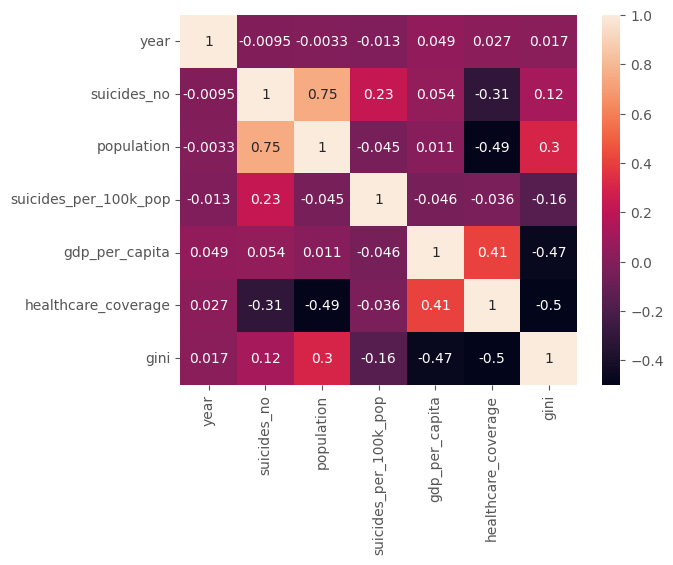

In [188]:
sns.heatmap(train_df.corr(),annot=True)

In [189]:
df.head()


,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,generation,country_code,continent,healthcare_coverage,gini
0,Australia,2010,male,35-54 years,816,3076853,26.5200000000,"1,144,260,547,873",54887,Generation X,AUS,Oceania,100.0000000000,34.7000000000
1,Australia,2010,male,75+ years,151,582009,25.9400000000,"1,144,260,547,873",54887,Silent,AUS,Oceania,100.0000000000,34.7000000000
2,Australia,2010,male,25-34 years,311,1606526,19.3600000000,"1,144,260,547,873",54887,Generation X,AUS,Oceania,100.0000000000,34.7000000000
3,Australia,2010,male,55-74 years,360,2051197,17.5500000000,"1,144,260,547,873",54887,Silent,AUS,Oceania,100.0000000000,34.7000000000
4,Australia,2010,male,15-24 years,222,1618860,13.7100000000,"1,144,260,547,873",54887,Millenials,AUS,Oceania,100.0000000000,34.7000000000


## Prepare data

In [190]:
X_cols = ['year','gdp_per_capita','healthcare_coverage','gini','population']
X_train = train_df[X_cols].values
Y_train = train_df['suicides_no'].values

X_test = test_df[X_cols].values
Y_test = test_df['suicides_no'].values

In [191]:
# take a look
# X_train.plot.scatter(x='year',)

In [192]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# create a standard scaler object and fit it to the training data
scaler = MinMaxScaler()#StandardScaler()
scaler.fit(X_train)

# transform the training and test data using the scaler
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## Linear regression model

In [193]:
#Import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

linear_model = LinearRegression(positive=False)
linear_model.fit(X_train_std, Y_train)

LinearRegression(positive=True)

In [194]:
# prediction
y_pred = linear_model.predict(X_test_std)
mean_squared_error(y_true=Y_test, y_pred=y_pred)

427195.7509763195

(276,) (276,)


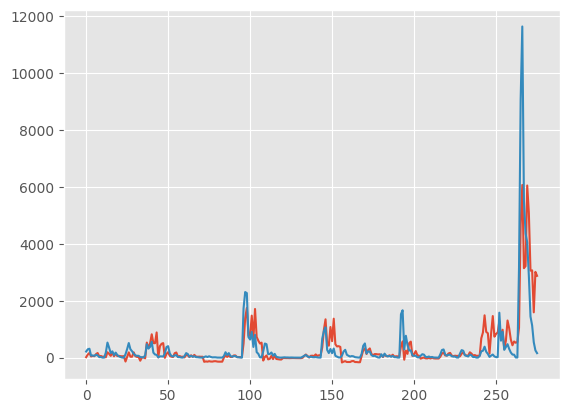

In [195]:
sns.lineplot(y_pred)
sns.lineplot(Y_test)
print(y_pred.shape,Y_test.shape)

(<AxesSubplot: ylabel='gt'>,)

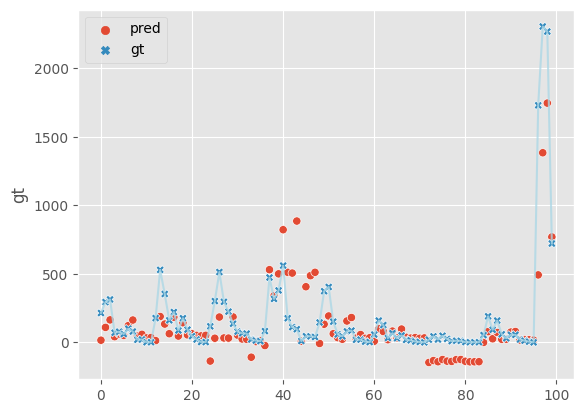

In [196]:
# look at an example
# X_test_std[:2,:]
linear_pred = linear_model.predict(X_test_std)
n_samples = 100
pred_df = pd.DataFrame({
    'pred' : linear_pred[:n_samples],
    'gt': Y_test[:n_samples]
})
sns.scatterplot(pred_df, markers=True)
sns.lineplot(pred_df['gt'], color='lightblue', alpha=.8),
# sns.lineplot(pred)
# sns.lineplot(Y_test[:5])
# X_test.shape

model looks ok, interestingly it predicts 0 partwise -> how to prevent? possible?

In [197]:
# subset = train_df[X_cols]
# subset[subset.population > 20_000_000]

## Decision tree regressor

In [198]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
dtr_model = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
dtr_model.fit(X_train_std, Y_train)

DecisionTreeRegressor(random_state=0)

(<AxesSubplot: ylabel='ground_truth'>,)

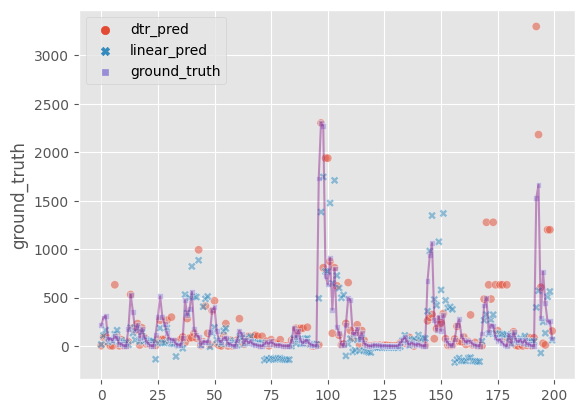

In [199]:
# look at an example
# X_test_std[:2,:]
dtr_pred = dtr_model.predict(X_test_std)
n_samples = 200
pred_df = pd.DataFrame({
    'dtr_pred' : dtr_pred[:n_samples],
    'linear_pred' : linear_pred[:n_samples],
    'ground_truth': Y_test[:n_samples]
})
sns.scatterplot(pred_df, markers=True, alpha=.5)
sns.lineplot(pred_df['ground_truth'], color='purple', alpha=.4),
# sns.lineplot(pred)
# sns.lineplot(Y_test[:5])
# X_test.shape

In [200]:
from sklearn.metrics import mean_absolute_error
# calc avg distance
linear_mse = mean_squared_error(y_true=Y_test, y_pred=linear_pred)
dtr_mse = mean_squared_error(y_true=Y_test, y_pred=dtr_pred)
print(f"{linear_mse=} | {dtr_mse=}")
linear_mae = mean_absolute_error(y_true=Y_test, y_pred=linear_pred)
dtr_mae = mean_absolute_error(y_true=Y_test, y_pred=dtr_pred)
print(f"{linear_mae=} | {dtr_mae=}")

linear_mse=427195.7509763195 | dtr_mse=456010.85869565216
linear_mae=282.58766027219394 | dtr_mae=191.05434782608697
